In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import csv
import sys

import network_distance as nd

In [2]:
backboned_n = "./data/00_FINAL_CYTOSCAPE/ADAPTED_209_countries_flights_norm_backbone_05_high_threshold.tsv"
country_n = "./data/00_FINAL_CYTOSCAPE/proximity_normalized_06_adapted.tsv"
cov_d = './data/0_Golden_Standard/cov_for_distance_01.csv'

In [3]:
country = pd.read_csv(country_n,sep='\t')
country

,src,trg,norm-log-prox
0,Afghanistan,China,0.066656
1,Afghanistan,Iran (Islamic Republic of),0.134148
2,Afghanistan,Pakistan,0.281125
3,Afghanistan,Tajikistan,0.259396
4,Afghanistan,Turkmenistan,0.172147
...,...,...,...
382,Vanuatu,Papua New Guinea,0.108375
383,Venezuela (Bolivarian Republic of),Grenada,0.221385
384,Virgin Islands (British),Anguilla,0.396131
385,Virgin Islands (British),Puerto Rico,0.407632


In [4]:
cov = pd.read_csv(cov_d,sep=',').drop(["Unnamed: 0"],axis=1).sort_values(by=["weeks_since_100_cases"],ascending=True)
cov

,src,iso_code_src,days_to_first_100_cases,weeks_since_100_cases
39,China,CHN,1.0,0
109,"Korea, Republic of",KOR,34.0,4
95,Iran (Islamic Republic of),IRN,40.0,5
100,Italy,ITA,37.0,5
102,Japan,JPN,35.0,5
...,...,...,...,...
150,Norfolk Island,NFK,999.0,142
149,Niue,NIU,999.0,142
65,Falkland Islands (Malvinas),FLK,999.0,142
183,Solomon Islands,SLB,999.0,142


In [5]:
drop_l = ["American Samoa", 
          "Christmas Island", 
          "Cocos (Keeling) Islands", 
          "Cook Islands", 
          "Falkland Islands (Malvinas)",
          "French Polynesia",
          "Lesotho",
          "Marshall Islands",
          "Netherlands Antilles"
          "Nauru",
          "Niue",
          "Saint Vincent and the Grenadines",
          "Swaziland",
          "Tuvalu",
          "Wallis and Futuna"
         ]
i_drop = cov[cov["src"].isin(drop_l)].index

cov = cov.drop(i_drop)

In [6]:
# Importing proximity
prox_data = open(country_n, "r")

next(prox_data, None)  # skip the first line in the input file
Graphtype = nx.Graph()

prox_w = nx.read_weighted_edgelist(prox_data, delimiter='\t', create_using=Graphtype, nodetype=str,)



In [7]:
# importing flights
fl_data = open(backboned_n, "r")

next(fl_data, None)  # skip the first line in the input file
Graphtype = nx.Graph()

fl_w = nx.read_weighted_edgelist(fl_data, 
                                 delimiter='\t', 
                                 create_using=Graphtype, 
                                 nodetype=str,)

In [8]:
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, './distance_measure/implementation')

In [9]:
def distance_measuring_all(df, src_c, w_c, netw):

    x_axis = []
    y_axis = []
    d_src = {}
    d_trg = {}
    
    prev_w = 0
    
    for idx, row in df.iterrows():   
        if row[w_c] < 100:
            
            if prev_w == row[w_c]:
                # add more countries to trg
                d_trg.update({row[src_c]:1})
                #print("Week {}: Adding more infected Countries: {}".format(row[w_c], d_trg.keys()))
                
                prev_w = row[w_c]
                
            else:
                # append old target to src
                for k, v in d_trg.items():
                     d_src.update({k:v})
                        
                d_trg.update({row[src_c]:1})
                
                if d_trg != {"China":1}:
                    #print("\n Week{}".format(row[w_c]))
                    #print("Src Countries:{}".format(d_src))
                    #print("Infected Countries:{}".format(d_trg))
                    
                    ge_dist = nd.ge(d_src, d_trg, netw)
                    if ge_dist != 0:
                        x_axis.append(row[w_c])
                        y_axis.append(ge_dist)
                    else:
                        print("Error with distance, verify nodes and edges")
                else:
                    pass
                prev_w = row[w_c]
            
    return x_axis, y_axis

def distance_measuring_new(df, src_c, w_c, netw):

    x_axis = []
    y_axis = []
    d_src = {}
    d_trg = {}
    
    prev_w = 0
    
    for idx, row in df.iterrows():   
        if row[w_c] < 100:
            
            if prev_w == row[w_c]:
                # add more countries to trg
                d_trg.update({row[src_c]:1})
                #print("Week {}: Adding more infected Countries: {}".format(row[w_c], d_trg.keys()))
                
                prev_w = row[w_c]
                
            else:
                # append old target to src
                for k, v in d_trg.items():
                     d_src.update({k:v})
                        
                d_trg = {row[src_c]:1}
                
                if d_trg != {"China":1}:
                    #print("\n Week{}".format(row[w_c]))
                    #print("Src Countries:{}".format(d_src))
                    #print("Infected Countries:{}".format(d_trg))
                    
                    ge_dist = nd.ge(d_src, d_trg, netw)
                    if ge_dist != 0:
                        x_axis.append(row[w_c])
                        y_axis.append(ge_dist)
                    else:
                        print("Error with distance, verify nodes and edges")
                else:
                    pass
                prev_w = row[w_c]
            
    return x_axis, y_axis



In [10]:
x_prox, y_prox = distance_measuring_all(cov, 'src', 'weeks_since_100_cases', netw = prox_w)
new_x_prox, new_y_prox = distance_measuring_new(cov, 'src', 'weeks_since_100_cases', netw = prox_w)
new_y_prox

[2.7009659111036273,
 2.1850267745330405,
 6.405073667702402,
 5.255035839714316,
 6.191508296758933,
 2.431933440087624,
 4.602457220687929,
 6.739144023684017,
 2.849354400407708,
 2.9691396515199124,
 2.9334216710759904,
 2.4486970353275295,
 6.621617208623887,
 5.7327482392637075,
 2.203773414783054,
 3.603166444430861,
 6.646619576282373,
 2.9768727935401387,
 3.0942545733694846,
 6.438710320704937]

In [11]:
x_fly, y_fly  = distance_measuring_all(cov, 'src', 'weeks_since_100_cases', netw = fl_w)
new_x_fly, new_y_fly  = distance_measuring_all(cov, 'src', 'weeks_since_100_cases', netw = fl_w)
new_y_fly

[1.0231883938383135,
 0.9513548138660693,
 0.27042637269607056,
 0.09705001637741366,
 0.09484430474866046,
 0.02609622723255486,
 0.02398861204700322,
 0.01544616782568171,
 0.013201811247148868,
 0.012436535618199579,
 0.011975140146089028,
 0.012511003271792786,
 0.011779220998800702,
 0.010911756898172309,
 0.010663497772795976,
 0.010742739300662569,
 0.010811875666558217,
 0.009496216833761967,
 0.011061825013597846,
 0.009381600899297312]

# Making the graph

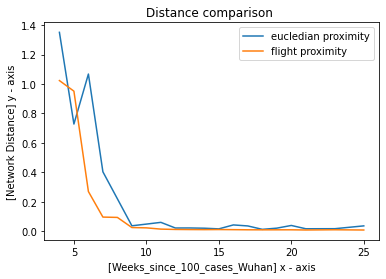

In [12]:
# Proximity line
plt.plot(x_prox, y_prox, label = "eucledian proximity")
# Flight line
plt.plot(x_fly, y_fly, label = "flight proximity")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('[Network Distance] y - axis')
# Set a title of the current axes.
plt.title('Distance comparison ')
# show a legend on the plot
plt.legend()

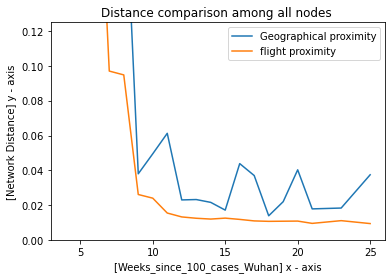

In [13]:
# Proximity line
plt.plot(x_prox, y_prox, label = "Geographical proximity")
# Flight line
plt.plot(x_fly, y_fly, label = "flight proximity")
plt.ylim(bottom = 0, top=0.125)
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('[Network Distance] y - axis')
# Set a title of the current axes.
plt.title('Distance comparison among all nodes ')
# show a legend on the plot
plt.legend()

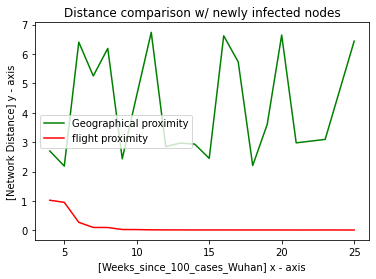

In [43]:
# Proximity line
plt.plot(new_x_prox, new_y_prox, label = "Geographical proximity", color="green")
# Flight line
plt.plot(new_x_prox, new_y_fly, label = "flight proximity", color="red")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('[Network Distance] y - axis')
# Set a title of the current axes.
plt.title('Distance comparison w/ newly infected nodes')
# show a legend on the plot
plt.legend()

In [21]:
def subtract(l1,l2):
    difference = []
    zip_object = zip(l1, l2)
    for l1_i, l2_i in zip_object:
        difference.append(l1_i-l2_i)
    return difference

def divide(l1,l2):
    difference = []
    zip_object = zip(l1, l2)
    for l1_i, l2_i in zip_object:
        difference.append(l1_i / l2_i)
    return difference

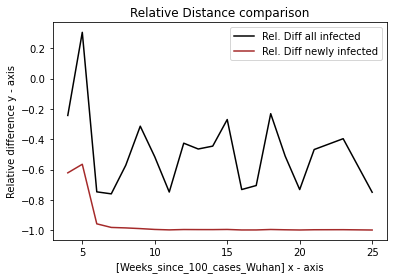

In [45]:
# Relative Differences

plt.plot(x_prox, divide(subtract(y_fly, y_prox), y_prox), label = "Rel. Diff all infected", color = "black")
plt.plot(new_x_prox, divide(subtract(new_y_fly, new_y_prox), new_y_prox), label = "Rel. Diff newly infected", color="brown")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('Relative difference y - axis')
# Set a title of the current axes.
plt.title('Relative Distance comparison')
# show a legend on the plot
plt.legend()

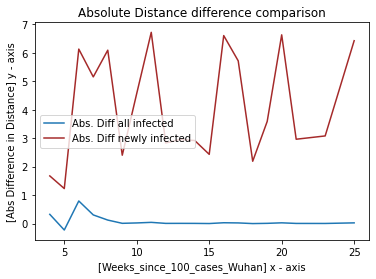

In [49]:
# Absolute Differences

plt.plot(x_prox, subtract(y_prox, y_fly), label = "Abs. Diff all infected")
plt.plot(new_x_prox, subtract(new_y_prox, new_y_fly), label = "Abs. Diff newly infected", color="brown")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('[Abs Difference in Distance] y - axis')
# Set a title of the current axes.
plt.title('Absolute Distance difference comparison')
# show a legend on the plot
plt.legend()

Improve plotting https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/psd_demo.html#sphx-glr-gallery-lines-bars-and-markers-psd-demo-py

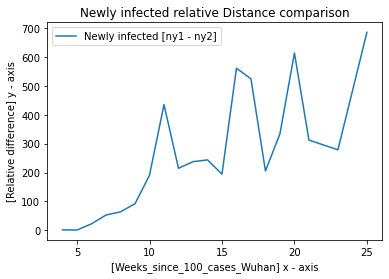

In [50]:
# Relative Differences

plt.plot(new_x_prox, divide(subtract(new_y_prox, new_y_fly), new_y_fly), label = "Newly infected [ny1 - ny2]")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('[Relative difference] y - axis')
# Set a title of the current axes.
plt.title('Newly infected relative Distance comparison')
# show a legend on the plot
plt.legend()



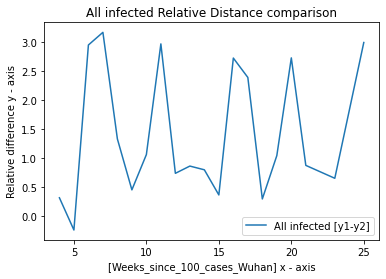

In [51]:
# Relative Differences

plt.plot(x_prox, divide(subtract(y_prox, y_fly), y_fly), label = "All infected [y1-y2]")
plt.xlabel('[Weeks_since_100_cases_Wuhan] x - axis')
# Set the y axis label of the current axis.
plt.ylabel('Relative difference y - axis')
# Set a title of the current axes.
plt.title('All infected Relative Distance comparison')
# show a legend on the plot
plt.legend()

